# Swish-based dense split ensemble with categorical entity embedding
- Wide-deep
- PRI_jet_num embedded
- Train-time/test-time data augmentation
- Onecycle
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
NAME = '16_swish_ensemble_embed_aug_onecycle_dense_wide-deep'

In [4]:
experiment = Experiment(NAME, 'helios_cuda', RESULTS_PATH)

In [5]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s {experiment.seed}

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI

## Training

### Import data

In [6]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [7]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


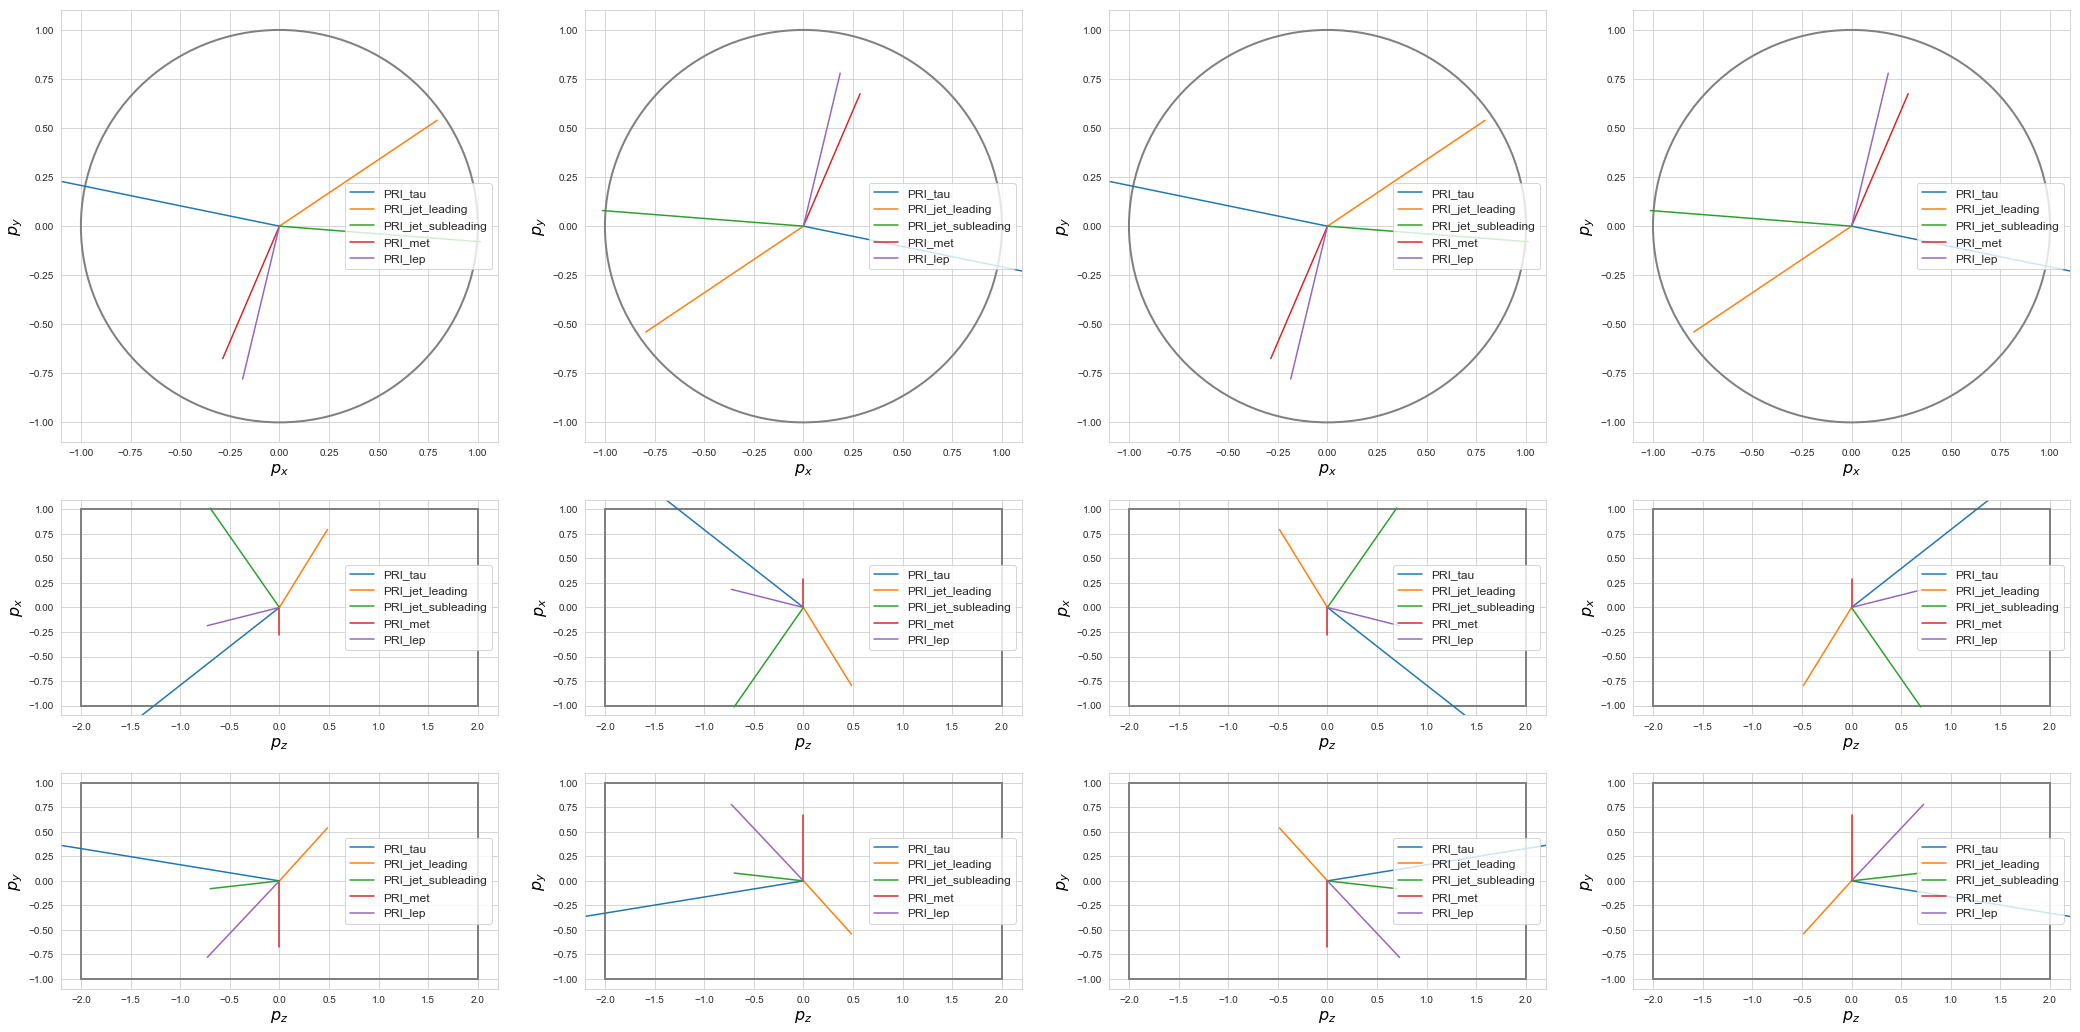

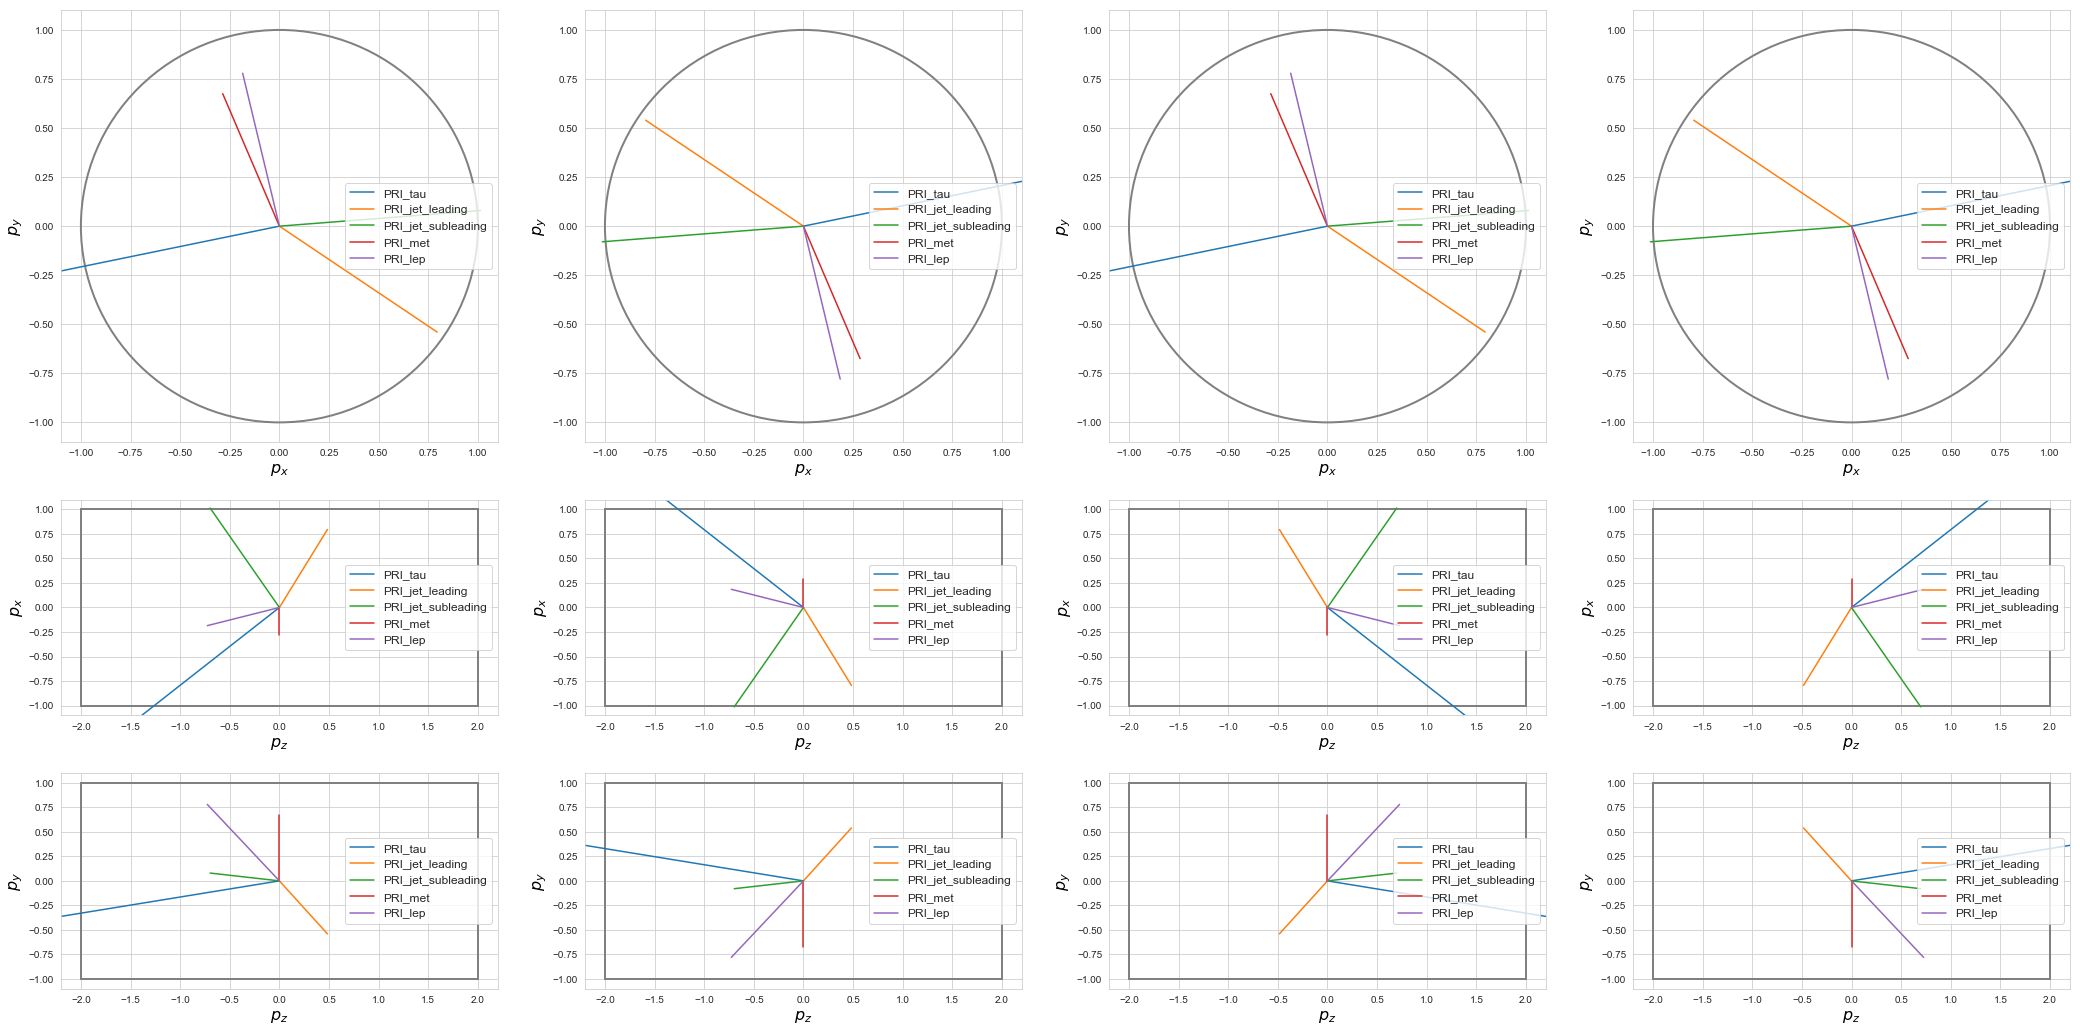

In [8]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


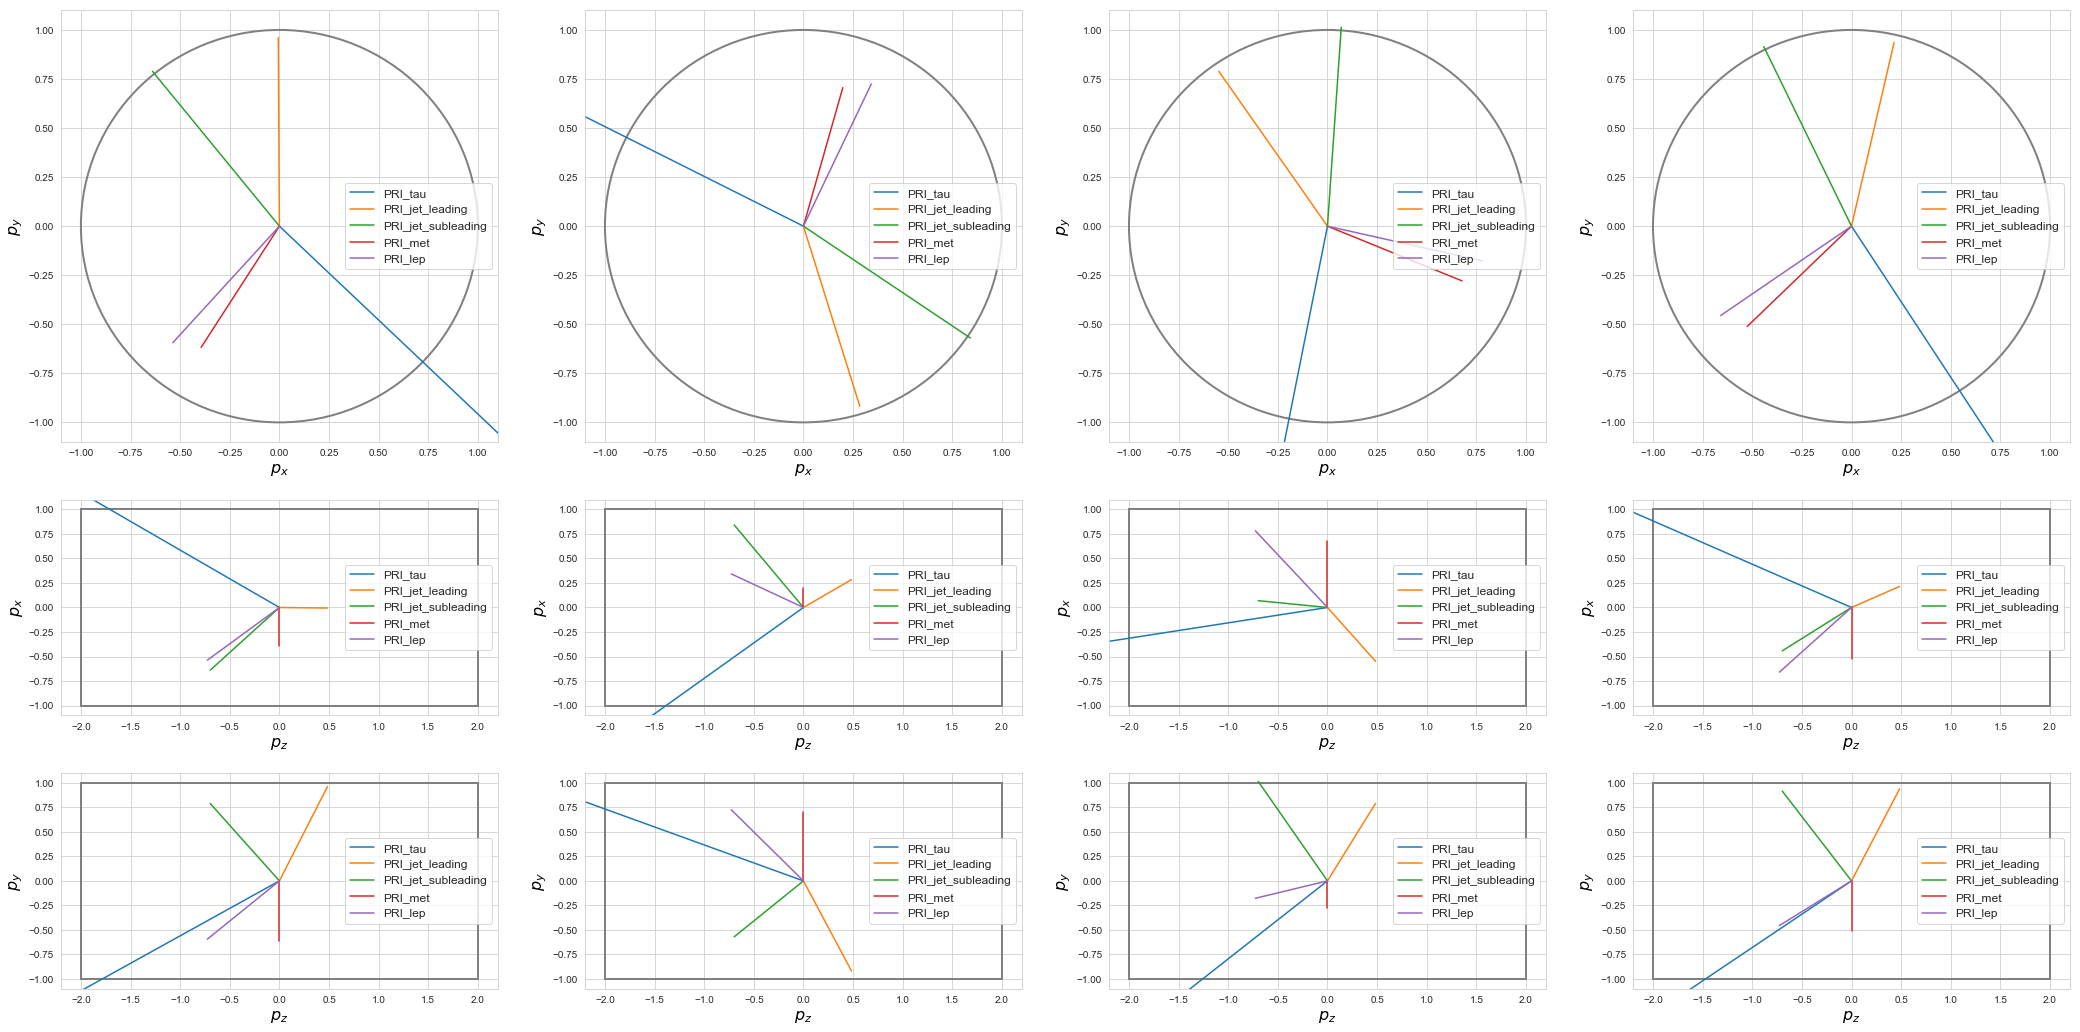

In [9]:
id=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1] for i in range(4)])

### Options

In [10]:
n_models = 10
patience = 50
max_epochs = 15
ensemble_size = 10

bs = 256
objective = 'classification'
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])

hl_feats = [f for f in train_feats if 'DER_' in f]
ll_feats = [f for f in train_feats if 'PRI_' in f]
body = partial(MultiBlock,
               blocks=[partial(FullyConnected, depth=1, width=50, act='swish'),
                       partial(FullyConnected, depth=6, width=33, act='swish', dense=True)],
               feats_per_block=[hl_feats,train_feats],
               bottleneck_sz=0, bottleneck_act='swish')

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             body=body, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (1): MultiBlock(
    (blocks): ModuleList(
      (0): FullyConnected(
        (layers): Sequential(
          (0): Sequential(
            (0): Linear(i

### Determine LR

LR finder took 5.076s 


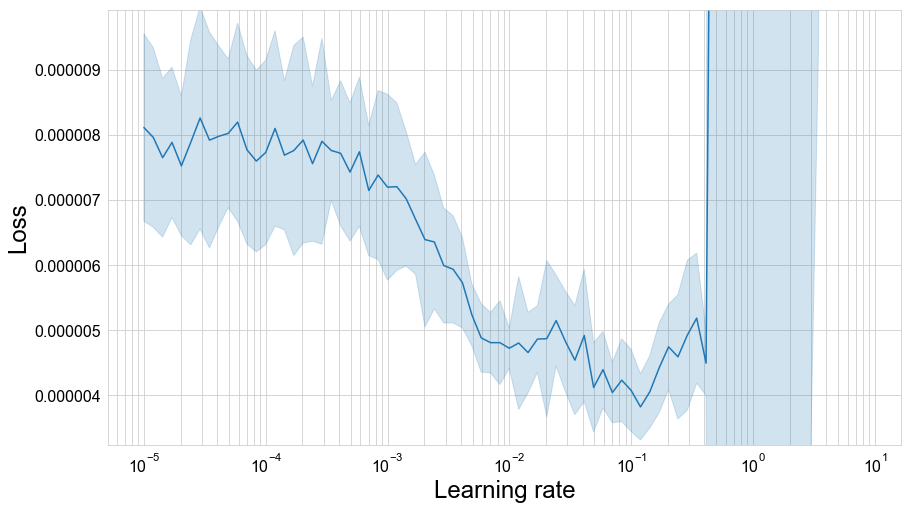

In [11]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [12]:
callback_partials = [partial(OneCycle, lengths=(45, 90), lr_range=[1e-4, 1e-2], mom_range=(0.85, 0.95), interp='cosine')]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}

Training model 1 / 10, Val ID = 0


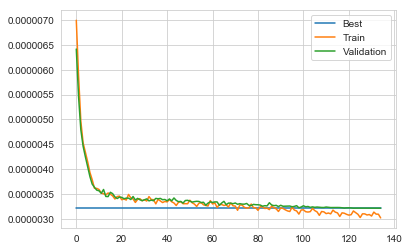

Early stopping after 135 epochs
Scores are: {'loss': 3.2147243018698646e-06, 'AMS': 4.245780921978067}
Fold took 78.778s

Training model 2 / 10, Val ID = 1


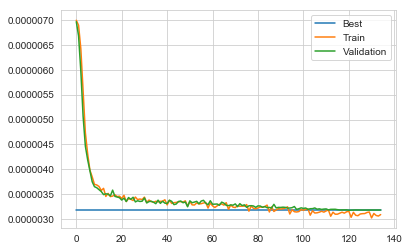

Early stopping after 135 epochs
Scores are: {'loss': 3.1786180443305057e-06, 'AMS': 3.9633841842316606}
Fold took 78.865s

Training model 3 / 10, Val ID = 2


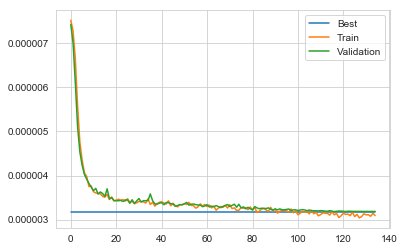

Early stopping after 135 epochs
Scores are: {'loss': 3.181230340487673e-06, 'AMS': 3.796836865711576}
Fold took 78.504s

Training model 4 / 10, Val ID = 3


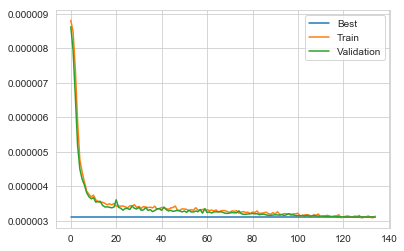

Early stopping after 135 epochs
Scores are: {'loss': 3.1070708246261347e-06, 'AMS': 4.2971823788970624}
Fold took 79.717s

Training model 5 / 10, Val ID = 4


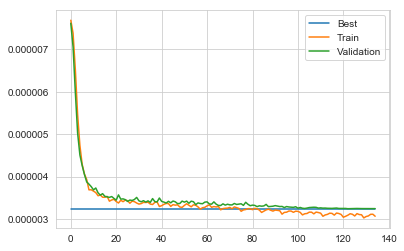

Early stopping after 135 epochs
Scores are: {'loss': 3.242794264224358e-06, 'AMS': 3.7068210263041896}
Fold took 77.095s

Training model 6 / 10, Val ID = 5


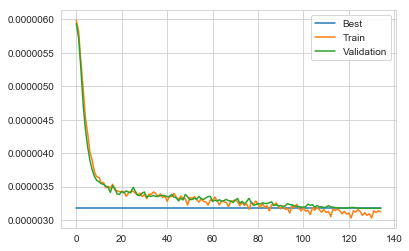

Early stopping after 135 epochs
Scores are: {'loss': 3.174024868712877e-06, 'AMS': 4.182960631193911}
Fold took 76.524s

Training model 7 / 10, Val ID = 6


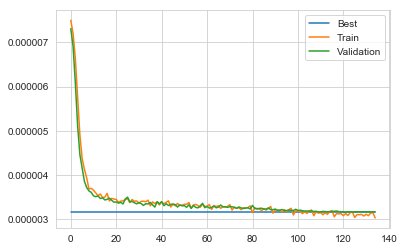

Early stopping after 135 epochs
Scores are: {'loss': 3.152490080537973e-06, 'AMS': 3.7888546583115033}
Fold took 77.564s

Training model 8 / 10, Val ID = 7


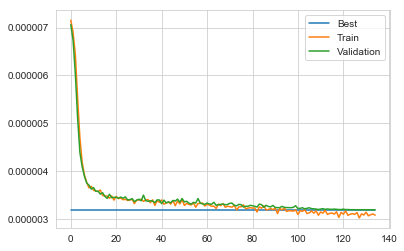

Early stopping after 135 epochs
Scores are: {'loss': 3.186332605764619e-06, 'AMS': 4.3940881583924}
Fold took 80.380s

Training model 9 / 10, Val ID = 8


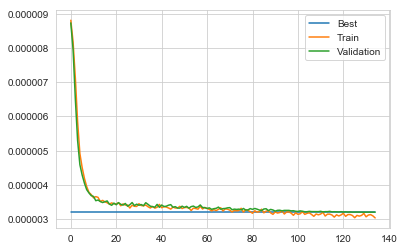

Early stopping after 135 epochs
Scores are: {'loss': 3.203373580618063e-06, 'AMS': 3.6627594827831427}
Fold took 78.990s

Training model 10 / 10, Val ID = 9


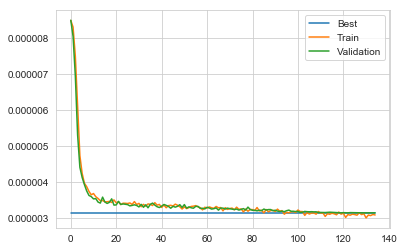

Early stopping after 135 epochs
Scores are: {'loss': 3.1532033517578384e-06, 'AMS': 4.044126107045081}
Fold took 74.825s


______________________________________
Training finished
Cross-validation took 781.247s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

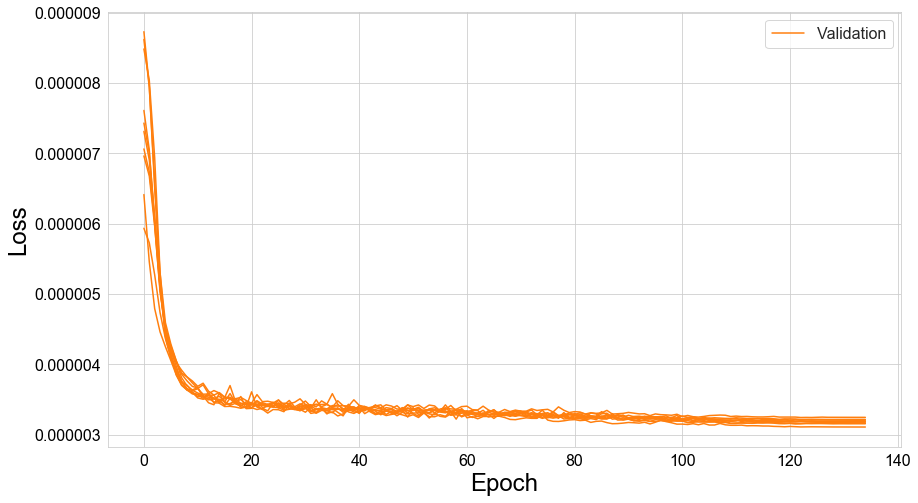

Mean loss = 3.18e-06±1e-08
Mean AMS = 4.01±0.08
______________________________________



In [13]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [14]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [15]:
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 3 with loss = 3.1070708246261347e-06
Model 1 is 6 with loss = 3.152490080537973e-06
Model 2 is 9 with loss = 3.1532033517578384e-06
Model 3 is 5 with loss = 3.174024868712877e-06
Model 4 is 1 with loss = 3.1786180443305057e-06
Model 5 is 2 with loss = 3.181230340487673e-06
Model 6 is 7 with loss = 3.186332605764619e-06
Model 7 is 8 with loss = 3.203373580618063e-06
Model 8 is 0 with loss = 3.2147243018698646e-06
Model 9 is 4 with loss = 3.242794264224358e-06


### Interpretation

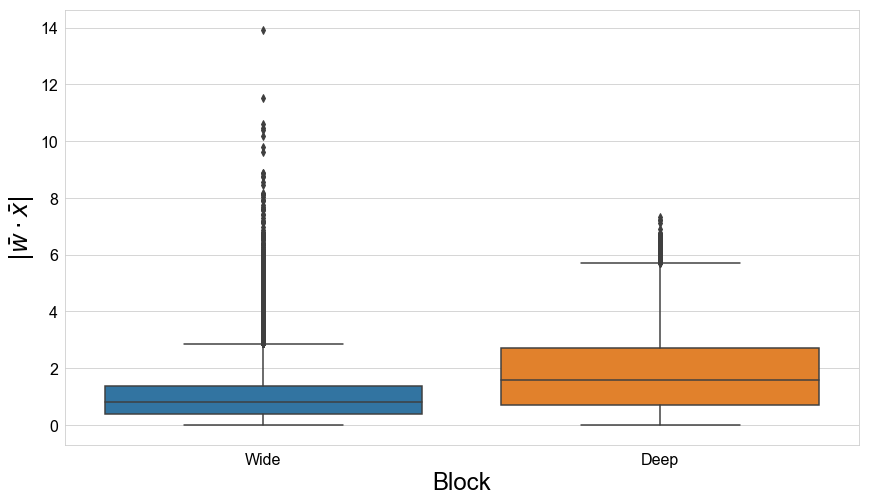

In [16]:
plot_multibody_weighted_outputs(ensemble[0][1], train_fy[2]['inputs'], ['Wide', 'Deep'], savename='wide_deep_hl_all', settings=plot_settings)

### Validation

#### Response on validation data without TTA

In [17]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [18]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time_no_tta'] = val_time

Mean time per event = 3.3e-06±9e-08


In [19]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.9437257647514343 corresponds to AMS of 3.676158060274459
Maximum AMS for data is 3.7137566659179146 at cut of 0.951911985874176


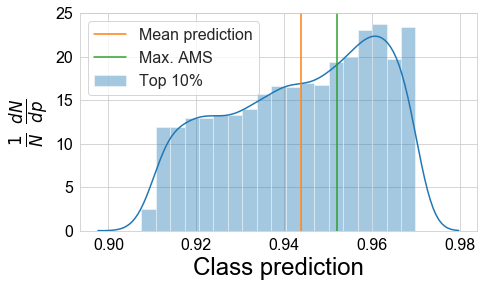

In [20]:
cut, experiment['val_ams_smooth_no_tta'], experiment['val_ams_max_no_tta'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

#### Response on validation data with TTA

In [21]:
val_fy = HEPAugFoldYielder(DATA_PATH/'val.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [22]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy, pred_name='pred_tta')
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 9.08e-05±4e-07


In [23]:
val_df = val_fy.get_df(pred_name='pred_tta')

50000 datapoints loaded


Mean cut at 0.9436163902282715 corresponds to AMS of 3.7018286594872185
Maximum AMS for data is 3.729054130290758 at cut of 0.9468919038772583


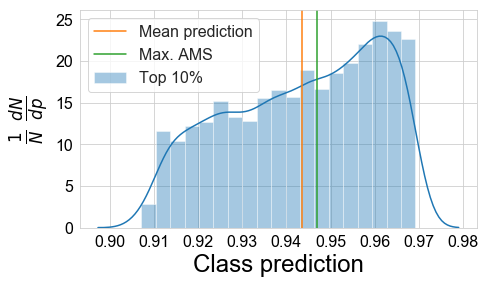

In [24]:
cut_tta, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring without TTA

In [25]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [26]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time_no_tta'] = test_time

Mean time per event = 1.23e-06±2e-08


In [27]:
experiment['test_public_ams_mean_no_tta'], experiment['test_private_ams_mean_no_tta'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.81±0.06 : 3.79±0.05


In [28]:
experiment['test_public_ams_no_tta'], experiment['test_private_ams_no_tta'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.793779020351748 : 3.7866706812930895


#### Test scoring with TTA

In [29]:
test_fy = HEPAugFoldYielder(DATA_PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [30]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy, pred_name='pred_tta')
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 3.606e-05±9e-08


In [31]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut_tta, pred_name='pred_tta')

Mean Public:Private AMS: 3.81±0.07 : 3.78±0.04


In [32]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut_tta, pred_name='pred_tta')

Public:Private AMS: 3.7957194725572903 : 3.7812713503460453


## Results 

In [33]:
experiment

Experiment:	16_swish_ensemble_embed_aug_onecycle_dense_wide-deep
Machine:	helios_cuda
Device:	Nvidia GeForce GTX 1080 Ti GPU
train_time	781.6050909260011
val_time_no_tta	0.1724084510024113
val_ams_smooth_no_tta	3.676158060274459
val_ams_max_no_tta	3.7137566659179146
val_time	4.544729283999914
val_ams_smooth	3.7018286594872185
val_ams_max	3.729054130290758
test_time_no_tta	0.6849112960007915
test_public_ams_mean_no_tta	(3.810038763407885, 0.06411359043948674)
test_private_ams_mean_no_tta	(3.7913508620818623, 0.04602137634323369)
test_public_ams_no_tta	3.793779020351748
test_private_ams_no_tta	3.7866706812930895
test_time	19.85220530299921
test_public_ams_mean	(3.812753963946887, 0.06733346452772361)
test_private_ams_mean	(3.784942158660224, 0.0428648746895207)
test_public_ams	3.7957194725572903
test_private_ams	3.7812713503460453

In [34]:
experiment.save()